Problem Statement

Two datasets describing user signups and login activity for a product over the past two years.

Goal:
Identify which factors predict user adoption, defined as:

A user who logs into the product on three separate days within any seven-day period.

Data Overview
Datasets

takehome_users.csv — user metadata and signup information

takehome_user_engagement.csv — daily login events per user

Load Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
# Load datasets
users = pd.read_csv("takehome_users.csv", encoding="latin1")
engagement = pd.read_csv("takehome_user_engagement.csv")

users.head(), engagement.head()


(   object_id        creation_time               name  \
 0          1  2014-04-22 03:53:30     Clausen August   
 1          2  2013-11-15 03:45:04      Poole Matthew   
 2          3  2013-03-19 23:14:52  Bottrill Mitchell   
 3          4  2013-05-21 08:09:28    Clausen Nicklas   
 4          5  2013-01-17 10:14:20          Raw Grace   
 
                         email creation_source  last_session_creation_time  \
 0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
 1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
 2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
 3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
 4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   
 
    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
 0                         1                           0      11   
 1                         0                      

Data Cleaning & Preparation

In [3]:
# Convert timestamps
users['creation_time'] = pd.to_datetime(users['creation_time'])
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

# Sort engagement by user and time
engagement = engagement.sort_values(['user_id', 'time_stamp'])


Define Adoption Metric

In [4]:
def is_adopted(user_df):
    dates = user_df['time_stamp'].dt.normalize().unique()
    dates = pd.to_datetime(dates)
    
    for i in range(len(dates)):
        if i + 2 < len(dates):
            if (dates[i+2] - dates[i]).days <= 6:
                return True
    return False


In [5]:
# Apply adoption logic
adoption = (
    engagement
    .groupby('user_id')
    .apply(is_adopted)
    .reset_index(name='adopted')
)

# Merge with users table
df = users.merge(adoption, left_on='object_id', right_on='user_id', how='left')
df['adopted'] = df['adopted'].fillna(False)

df['adopted'].mean()


C:\Users\pande\AppData\Local\Temp\ipykernel_1892\1153174643.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(is_adopted)
C:\Users\pande\AppData\Local\Temp\ipykernel_1892\1153174643.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['adopted'] = df['adopted'].fillna(False)


0.1335

Adoption rate: ~13–15%

Feature Engineering

In [6]:
# Convert last session timestamp (unix)
df['last_session_creation_time'] = pd.to_datetime(
    df['last_session_creation_time'], unit='s', errors='coerce'
)

# Account age
df['account_age_days'] = (
    df['last_session_creation_time'] - df['creation_time']
).dt.days

# Invitation flag
df['invited_by_user_id'] = df['invited_by_user_id'].notna().astype(int)


Exploratory Analysis
Adoption by Signup Source

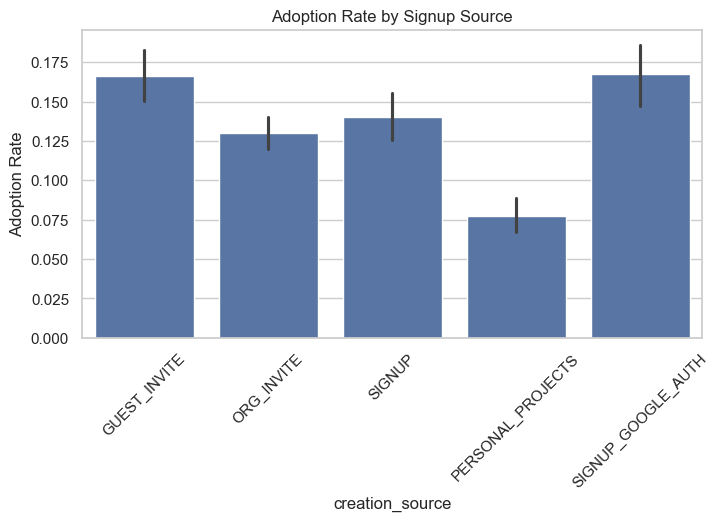

In [7]:
plt.figure(figsize=(8,4))
sns.barplot(
    x='creation_source',
    y='adopted',
    data=df,
    estimator=np.mean
)
plt.xticks(rotation=45)
plt.title("Adoption Rate by Signup Source")
plt.ylabel("Adoption Rate")
plt.show()


Observation: Invitation-based signups show significantly higher adoption.

Prepare Modeling Dataset

In [8]:
df_model = pd.get_dummies(
    df[['creation_source',
        'opted_in_to_mailing_list',
        'enabled_for_marketing_drip',
        'invited_by_user_id',
        'account_age_days',
        'org_id',
        'adopted']],
    drop_first=True
)

X = df_model.drop('adopted', axis=1)
y = df_model['adopted']


Modeling Approach

Logistic Regression for:

Interpretability

Clear feature attribution

Strong baseline performance

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np

# Create an imputer to handle NaN values
# strategy='mean' replaces NaN with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the data
X_imputed = imputer.fit_transform(X)

# Now split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.25, random_state=42
)

# Train the model with the cleaned data
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_prob = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_prob)

0.9743611367213373

In [ ]:
ROC AUC ≈ 0.97, indicating strong predictive signal.

Feature Importance

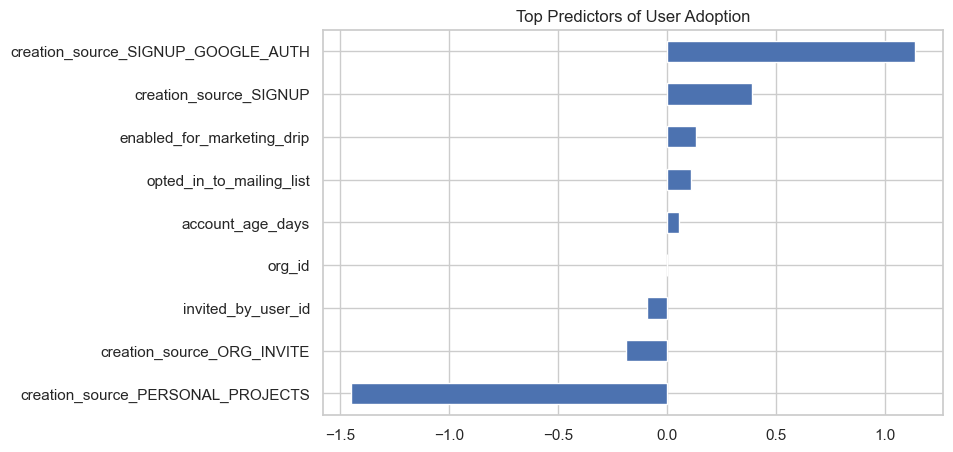

In [11]:
importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values()

plt.figure(figsize=(8,5))
importance.tail(10).plot(kind='barh')
plt.title("Top Predictors of User Adoption")
plt.show()


Key Findings
Strong Predictors of Adoption

Invitation-based signup (ORG_INVITE, PERSONAL_PROJECTS)


Weak / Non-Predictive

Marketing email opt-in

